In [1]:
import os
os.chdir('/Users/mikelgallo/repos2/DeepL_test')

In [2]:
# imports
#Data Manipulation
import pandas as pd
import numpy as pd
import klib

#Model fitting, performance, balancing
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors 
from sklearn.model_selection import train_test_split
from Functions.helper_functions import *
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVR , SVC

## Loading Data

#### Reading Datasets

In [3]:
#Path to datasets
data_path = './Session 1_ Nearest Neighbors/data/'

# Read data Train 
df = pd.read_csv(data_path+'mimic_train.csv')

# Read data Test
df_test = pd.read_csv(data_path+'mimic_test_death.csv')

# Read Metadata
df_meta = pd.read_csv(data_path+'MIMIC_metadata_diagnose.csv')

#There is a large difference 
print(df.shape)
print(df_test.shape)

(20885, 44)
(5221, 39)


#### Cleaning Datasets

In [4]:
# Select columns in test and add the Outcome variable to subset our train data set
df_test_cols = df_test.columns.tolist()
df_test_cols.append('HOSPITAL_EXPIRE_FLAG')

#Creating new subsetss
df_train = df[df_test_cols]

print(df_train.shape)
print(df_test.shape)

(20885, 40)
(5221, 39)


In [5]:
#Left join with metadata to get short_diagnosis
for i in df_meta:
    print(i)
    print(len(df_meta[i].unique()))
    print(df_meta[i].unique())

ICD9_CODE
14567
['436' '78001' 'E0062' ... 'E8389' 'E9263' '05920']
SHORT_DIAGNOSE
14328
['Cva' 'Coma' 'Golf' ... 'Wtrcrft acc NEC-pers NOS'
 'X-ray/gamma ray exposure' 'Yatapoxvirus infectn NOS']
LONG_DIAGNOSE
14562
['Acute, but ill-defined, cerebrovascular disease' 'Coma'
 'Activities involving golf' ...
 'Other and unspecified water transport accident injuring unspecified person'
 'Exposure to x-rays and other electromagnetic ionizing radiation'
 'Yatapoxvirus infection, unspecified']


## Split Columns Numeric and Non-numeric

In [6]:
#STEP 1 - Split columns into Continuous, Discrete, Categorical
def numeric_cols(dataset):
    numeric = dataset.select_dtypes(include = np.number).columns.tolist()
    return numeric
#STEP 2 - Rough Estimate of Continuous and Discrete columns
def cont_or_disc(dataset,num):
    dict = {}
    numeric = numeric_cols(dataset)
    df_numeric = dataset[numeric]
    for i in df_numeric:
        count = df_numeric[i].count()
        unique_vals = len(df_numeric[i].unique())
        type = 'Discrete' if unique_vals < num else 'Continuous'
        dtype = df_numeric[i].dtype
        dict[i] = [count, unique_vals, type, dtype]
    result = pd.DataFrame.from_dict(dict,orient='index',columns=['count', 'unique_vals', 'type', 'dtype'])
    return result
#STEP 3 - Return column names for discrete and continuous    
def numeric_col_split(df,num):
    new_df = cont_or_disc(df,num)
    cont_cols = []
    disc_cols = []
    for index,row in new_df.iterrows():
        if row['type'] == 'Discrete':
            disc_cols.append(index)
        elif row['type'] == 'Continuous':
            cont_cols.append(index)
    return disc_cols, cont_cols        

In [7]:
# Classify numeric as Continuous and Discrete
disc_cols, cont_cols  = numeric_col_split(df_train,10)
# Conitnuous columns
print('Continuous')
print(cont_cols)
# Discrete columns
print('Dsicrete')
print(disc_cols)

Continuous
['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'Diff']
Dsicrete
['HOSPITAL_EXPIRE_FLAG']


#### Continuous Variables

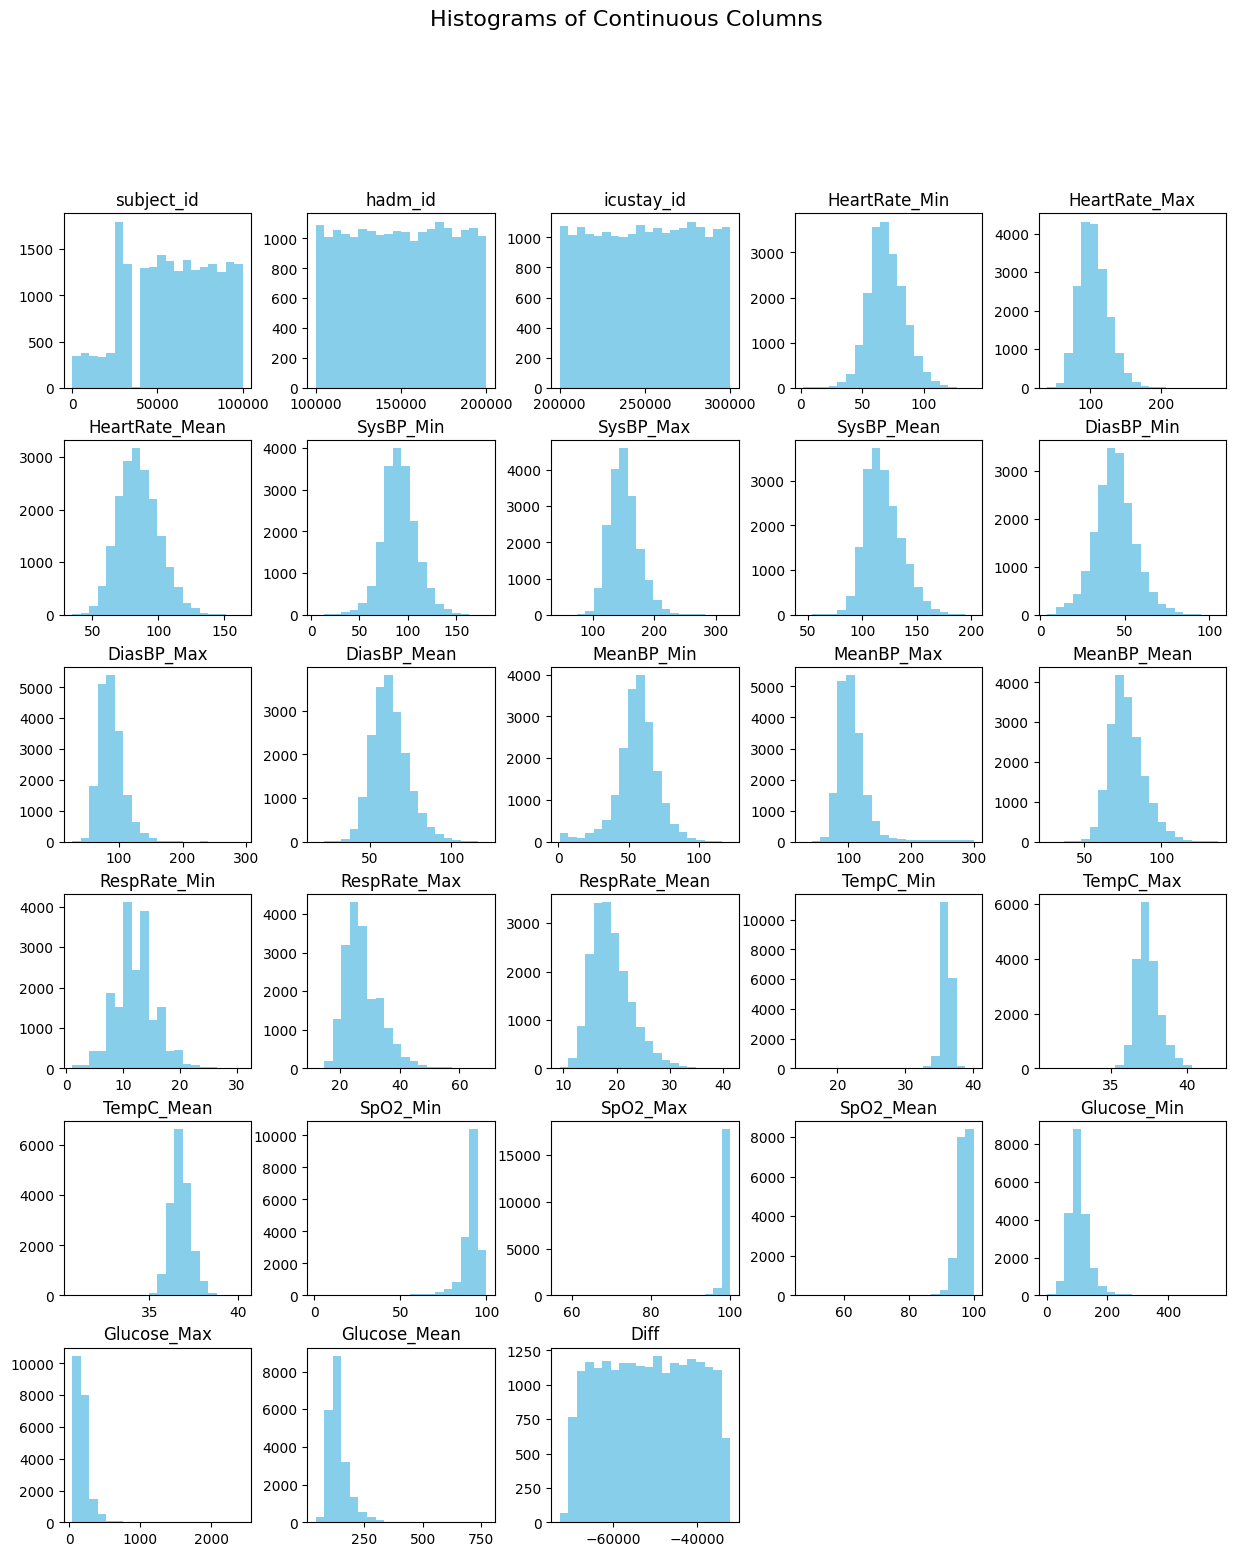

In [8]:
## Create Graph to analyze distributions of continuous variables
df_train[cont_cols].hist(bins=20, figsize=(15, 17), grid=False, color='skyblue')
plt.suptitle('Histograms of Continuous Columns', y=1, size=16)
plt.show()

 - There seems to be cases of correlated metrics, like the case of TempC_max and TempC_mean
 - We need to take care of ID's and Diff variables as they have very uniform distributions (don't seem to add value)
 - Probably we'll need to reduce dimensionality
 - We'll use Subject_id to calculate the frequency in which the patients have been sick and label encode with frequency
 - Check correlation between Target and Diff 

In [9]:
#Create a new variable for subject_id, which will be encoded with the frequency in which they get sick

def freq_encoding(df,variable_to_encode):
    # Step 1: Calculate the frequency of each category
    frequency_mapping = df[variable_to_encode].value_counts()
    # Step 2: Map categories to their frequencies
    df['subject_id_enc'] = df[variable_to_encode].map(frequency_mapping)


In [10]:
# Label Encode and add to dataframe
freq_encoding(df_train,'subject_id')
freq_encoding(df_test,'subject_id')

/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_48724/1953522261.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subject_id_enc'] = df[variable_to_encode].map(frequency_mapping)


In [11]:
#Remove Diff Column *
df_train = df_train.drop(['Diff'],axis=1)
df_test = df_test.drop(['Diff'],axis=1)

In [12]:
df_train.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'GENDER', 'DOB',
       'ADMITTIME', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT', 'HOSPITAL_EXPIRE_FLAG', 'subject_id_enc'],
      dtype='object')

### Categorical Variables

In [13]:
def categoricals(dataset):
    dict = {}
    for i in dataset:
        count = dataset[i].count()
        unique_vals = len(dataset[i].unique())
        dtype = dataset[i].dtype
        dict[i] = [count, unique_vals, dtype]
    result = pd.DataFrame.from_dict(dict,orient='index',columns=['count', 'unique_vals','dtype'])
    return result

In [14]:
#Retrieving only non-numeric columnss
numerics = numeric_cols(df_train)
non_numeric = [col for col in df_train.columns if col not in numerics]

#Check Data
df_train[non_numeric].head()

,GENDER,DOB,ADMITTIME,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
0,F,2108-07-16 00:00:00,2178-02-06 10:35:00,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU
1,F,2087-01-16 00:00:00,2129-02-12 22:34:00,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU
2,F,2057-09-17 00:00:00,2125-11-17 23:04:00,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU
3,F,2056-02-27 00:00:00,2131-01-26 08:00:00,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU
4,F,2066-12-19 00:00:00,2146-05-04 02:02:00,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU


In [15]:
for i in df_train[non_numeric]:
    if len(df_train[i].unique()) <= 5:
        print(i)
        print(df_train[i].unique())

GENDER
['F' 'M']
ADMISSION_TYPE
['EMERGENCY' 'ELECTIVE' 'URGENT']
INSURANCE
['Medicare' 'Private' 'Medicaid' 'Self Pay' 'Government']
FIRST_CAREUNIT
['MICU' 'SICU' 'TSICU' 'CSRU' 'CCU']


In [16]:
#Check Marital Status Distribution
expl_Marital = pd.DataFrame(df_train[non_numeric].groupby('MARITAL_STATUS')['GENDER'].count().reset_index())
expl_Marital['perc'] = expl_Marital['GENDER'] / expl_Marital['GENDER'].sum()
expl_Marital.sort_values(by='perc',ascending=False)

,MARITAL_STATUS,GENDER,perc
2,MARRIED,9664,0.479294
4,SINGLE,5910,0.293111
6,WIDOWED,2819,0.139811
0,DIVORCED,1413,0.070079
3,SEPARATED,240,0.011903
5,UNKNOWN (DEFAULT),103,0.005108
1,LIFE PARTNER,14,0.000694


In [17]:
#Check Marital Status Distribution
expl_Marital = pd.DataFrame(df_test[non_numeric].groupby('MARITAL_STATUS')['GENDER'].count().reset_index())
expl_Marital['perc'] = expl_Marital['GENDER'] / expl_Marital['GENDER'].sum()
expl_Marital.sort_values(by='perc',ascending=False)

,MARITAL_STATUS,GENDER,perc
2,MARRIED,2461,0.488197
4,SINGLE,1438,0.285261
6,WIDOWED,709,0.140647
0,DIVORCED,353,0.070026
3,SEPARATED,51,0.010117
5,UNKNOWN (DEFAULT),28,0.005554
1,LIFE PARTNER,1,0.000198


- We will impute missing values using KNNimputer

### Label Encoding Marital Status

In [18]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_train['MARITAL_STATUS'] = label_encoder.fit_transform(df_train['MARITAL_STATUS'])
df_test['MARITAL_STATUS'] = label_encoder.transform(df_test['MARITAL_STATUS'])

In [19]:
df_train['MARITAL_STATUS'] = [np.nan if i ==7 else i for i in df_train['MARITAL_STATUS']]
df_test['MARITAL_STATUS'] = [np.nan if i ==7 else i for i in df_test['MARITAL_STATUS']]

### Label Encoding Gender

In [20]:
gender_enc = [1 if i == 'M' else 0 for i in df_train['GENDER']]
gender_enc_t = [1 if i == 'M' else 0 for i in df_test['GENDER']]

df_train['GENDER_ENC'] = gender_enc
df_test['GENDER_ENC'] = gender_enc_t

### Label Encoding Admission Type

In [21]:
from sklearn.preprocessing import StandardScaler
admiss_type_enc = [3 if i == 'EMERGENCY' else 2 if i == 'URGENT' else 1 for i in df_train['ADMISSION_TYPE']]
admiss_type_enc_t = [3 if i == 'EMERGENCY' else 2 if i == 'URGENT' else 1 for i in df_test['ADMISSION_TYPE']]

df_train['ADMISSION_TYPE_ENC'] = admiss_type_enc
df_test['ADMISSION_TYPE_ENC'] = admiss_type_enc_t

### Create Dummies INSURANCE

In [22]:
def encode(df, columns_hot):
    encoded_df = pd.get_dummies(df, columns=columns_hot, dtype=float)
    return encoded_df
#E.g. df = encode(df, ['orientation', 'neighborhood'])

In [23]:
df_train = encode(df_train,['INSURANCE'])
df_test = encode(df_test,['INSURANCE'])

### Create Age variable

In [24]:
##TRAIN

#Step1 - convert object to date + remove H-m-s
df_train['ADMITTIME'] = pd.to_datetime(df_train['ADMITTIME'], errors='coerce', infer_datetime_format=True).dt.date
df_train['DOB'] = pd.to_datetime(df_train['DOB'], errors='coerce', infer_datetime_format=True).dt.date

#Step2 - Calculate day difference
df_train['AGE'] = df_train['ADMITTIME'] - df_train['DOB']

#Step3 - Extract days (int)
df_train['AGE'] = [i.days for i in df_train['AGE']]

#Step4 - Convert to years
df_train['AGE'] = (df_train['AGE']/365).round()

##TEST

#Step1 - convert object to date + remove H-m-s
df_test['ADMITTIME'] = pd.to_datetime(df_test['ADMITTIME'], errors='coerce', infer_datetime_format=True).dt.date
df_test['DOB'] = pd.to_datetime(df_test['DOB'], errors='coerce', infer_datetime_format=True).dt.date

#Step2 - Calculate day difference
df_test['AGE'] = df_test['ADMITTIME'] - df_test['DOB']

#Step3 - Extract days (int)
df_test['AGE'] = [i.days for i in df_test['AGE']]

#Step4 - Convert to years
df_test['AGE'] = (df_test['AGE']/365).round()

/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_48724/263149474.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_train['ADMITTIME'] = pd.to_datetime(df_train['ADMITTIME'], errors='coerce', infer_datetime_format=True).dt.date
/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_48724/263149474.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_train['DOB'] = pd.to_datetime(df_train['DOB'], errors='coerce', infer_datetime_format=True).dt.date
/var/folders/pv/kfw019zx6lq5tdq_s52kkbzc0000gn/T/ipykernel_48724/263149474.py:19: UserWarn

<Axes: >

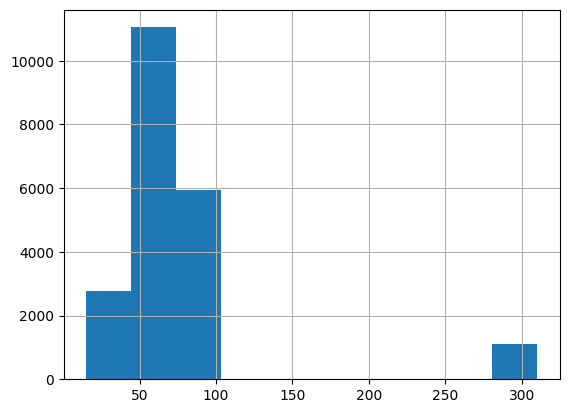

In [25]:
df_train.AGE.hist()

In [26]:
df_train.AGE.describe()

count    20885.000000
mean        75.404405
std         55.679250
min         15.000000
25%         53.000000
50%         66.000000
75%         78.000000
max        310.000000
Name: AGE, dtype: float64

In [27]:
## Replace all values >= 300 for 89
df_train['AGE'] = [89 if i >= 300 else i for i in df_train['AGE']]
df_test['AGE'] = [89 if i >= 300 else i for i in df_test['AGE']]

<Axes: >

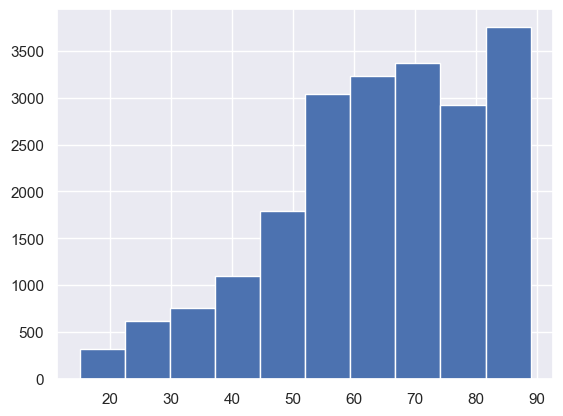

In [519]:
df_train.AGE.hist()

In [28]:
df_train['AGE'].describe().round()

count    20885.0
mean        64.0
std         17.0
min         15.0
25%         53.0
50%         66.0
75%         78.0
max         89.0
Name: AGE, dtype: float64

### Missing Values

In [520]:
df_train.isna().mean()

subject_id              0.000000
hadm_id                 0.000000
icustay_id              0.000000
HeartRate_Min           0.104716
HeartRate_Max           0.104716
HeartRate_Mean          0.104716
SysBP_Min               0.105722
SysBP_Max               0.105722
SysBP_Mean              0.105722
DiasBP_Min              0.105770
DiasBP_Max              0.105770
DiasBP_Mean             0.105770
MeanBP_Min              0.104668
MeanBP_Max              0.104668
MeanBP_Mean             0.104668
RespRate_Min            0.104812
RespRate_Max            0.104812
RespRate_Mean           0.104812
TempC_Min               0.119559
TempC_Max               0.119559
TempC_Mean              0.119559
SpO2_Min                0.105482
SpO2_Max                0.105482
SpO2_Mean               0.105482
Glucose_Min             0.012114
Glucose_Max             0.012114
Glucose_Mean            0.012114
GENDER                  0.000000
DOB                     0.000000
ADMITTIME               0.000000
ADMISSION_

In [521]:
#Defining columns to scale
numerics = numeric_cols(df_train)
#Columns to filter
not_scale = ['subject_id','hadm_id','icustay_id','MARITAL_STATUS','HOSPITAL_EXPIRE_FLAG','GENDER_ENC','INSURANCE_Government','INSURANCE_Medicaid', 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Self Pay']
new_cont_list = [col for col in numerics if col not in not_scale]
print(new_cont_list)

['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'subject_id_enc', 'ADMISSION_TYPE_ENC', 'AGE']


### Scaling Data for Imputation of continuous variables

In [522]:
#Step 1 - Scale data
from sklearn.preprocessing import StandardScaler
scaler3 = StandardScaler()

df_train[new_cont_list] = scaler3.fit_transform(df_train[new_cont_list])
df_test[new_cont_list] = scaler3.transform(df_test[new_cont_list])

### KNN imputation 'Continuous'

In [523]:
# Creating a new list for KNN imputation
new_cont_list.extend(['GENDER_ENC','INSURANCE_Government','INSURANCE_Medicaid', 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Self Pay'])

In [524]:
# KNN imputation
from sklearn.impute import KNNImputer
# Create a KNNImputer object with k=3 
imputer = KNNImputer(n_neighbors=5) 

# Perform KNN imputation only on the specified columns for the training data
df_train[new_cont_list] = imputer.fit_transform(df_train[new_cont_list])

# Perform KNN imputation on the same columns for the test data (use the same imputer)
df_test[new_cont_list] = imputer.transform(df_test[new_cont_list])

### KNN imputation 'MARITAL_STATUS'

In [525]:
# Creating a new list for KNN imputation
new_cont_list.extend(['MARITAL_STATUS'])

In [526]:
imputer2 = KNNImputer(n_neighbors=3) 

# Perform KNN imputation only on the specified columns for the training data
df_train[new_cont_list] = imputer2.fit_transform(df_train[new_cont_list])

# Perform KNN imputation on the same columns for the test data (use the same imputer)
df_test[new_cont_list] = imputer2.transform(df_test[new_cont_list])

In [527]:
df_train['MARITAL_STATUS']=df_train['MARITAL_STATUS'].round().astype(int)
df_test['MARITAL_STATUS']=df_test['MARITAL_STATUS'].round().astype(int)
print(df_train['MARITAL_STATUS'].unique())
print(df_test['MARITAL_STATUS'].unique())

[4 2 3 6 0 5 1]
[2 6 4 0 5 3 1]


### Dummies for MARITAL_STATUS

In [528]:
df_train = encode(df_train,['MARITAL_STATUS'])
df_test = encode(df_test,['MARITAL_STATUS'])

### Correlation Analysis

In [529]:
# Variables to compare
numerics = numeric_cols(df_train)
numerics_cont = ['HeartRate_Min',
 'HeartRate_Max',
 'HeartRate_Mean',
 'SysBP_Min',
 'SysBP_Max',
 'SysBP_Mean',
 'DiasBP_Min',
 'DiasBP_Max',
 'DiasBP_Mean',
 'MeanBP_Min',
 'MeanBP_Max',
 'MeanBP_Mean',
 'RespRate_Min',
 'RespRate_Max',
 'RespRate_Mean',
 'TempC_Min',
 'TempC_Max',
 'TempC_Mean',
 'SpO2_Min',
 'SpO2_Max',
 'SpO2_Mean',
 'Glucose_Min',
 'Glucose_Max',
 'Glucose_Mean',
 'HOSPITAL_EXPIRE_FLAG']

<Axes: title={'center': 'Feature-correlation (pearson)'}>

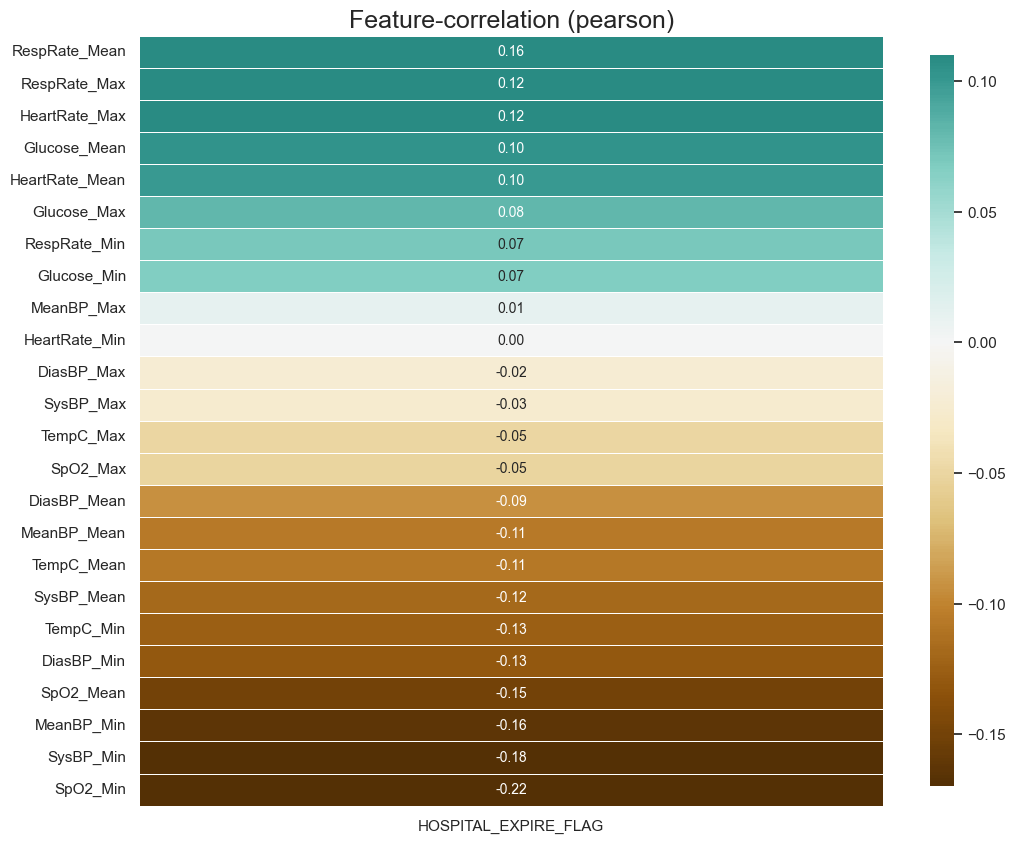

In [530]:
klib.corr_plot(df_train[numerics_cont], target='HOSPITAL_EXPIRE_FLAG') # default representation of correlations with the feature column

Displaying positive correlations. Specify a positive "threshold" to limit the results further.


<Axes: title={'center': 'Feature-correlation (pearson)'}>

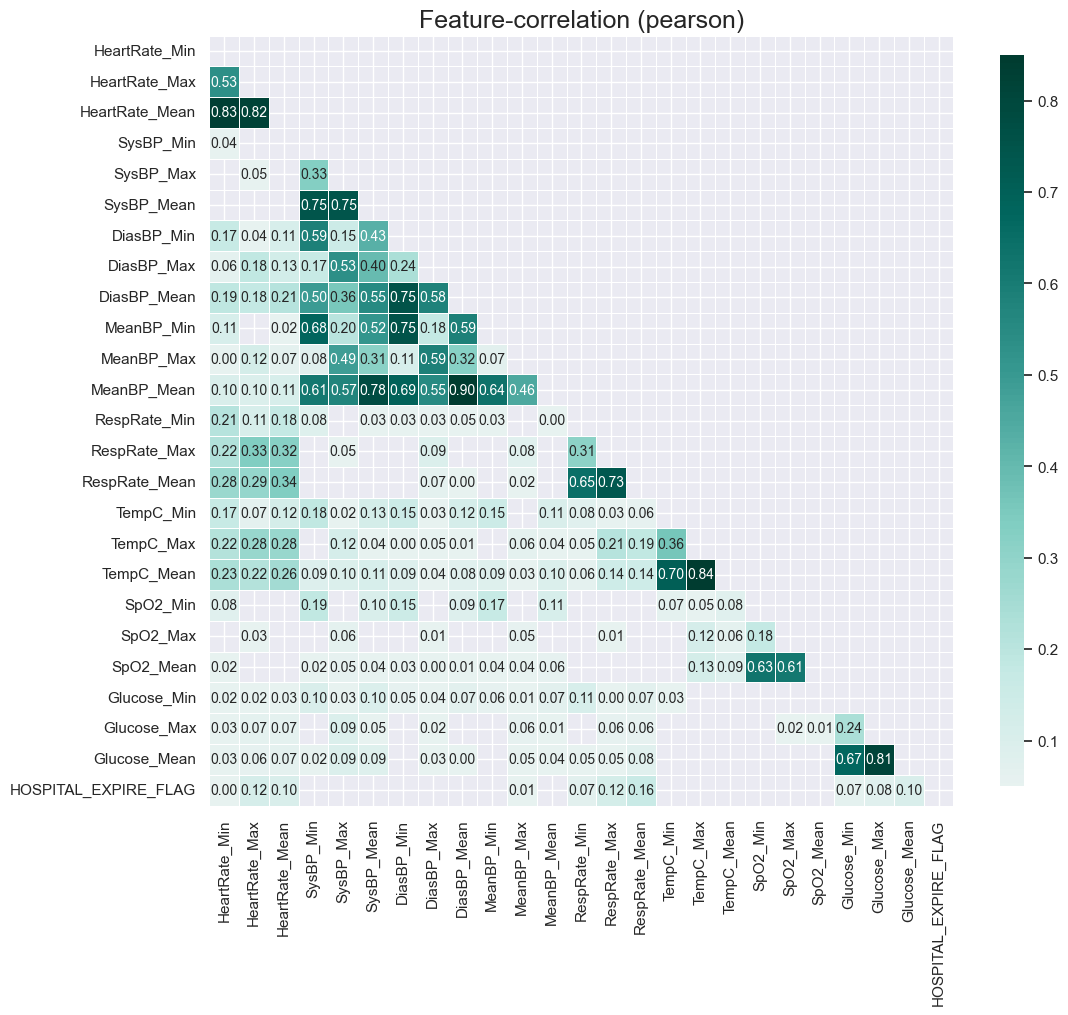

In [531]:
klib.corr_plot(df_train[numerics_cont],split='pos')

In [532]:
#rest of variables
others = [i for i in numerics if i not in numerics_cont]
others.append( 'HOSPITAL_EXPIRE_FLAG')
list_rm = ['subject_id','hadm_id','icustay_id']
others = [i for i in others if i not in list_rm]
others

['subject_id_enc',
 'GENDER_ENC',
 'ADMISSION_TYPE_ENC',
 'INSURANCE_Government',
 'INSURANCE_Medicaid',
 'INSURANCE_Medicare',
 'INSURANCE_Private',
 'INSURANCE_Self Pay',
 'AGE',
 'MARITAL_STATUS_0',
 'MARITAL_STATUS_1',
 'MARITAL_STATUS_2',
 'MARITAL_STATUS_3',
 'MARITAL_STATUS_4',
 'MARITAL_STATUS_5',
 'MARITAL_STATUS_6',
 'HOSPITAL_EXPIRE_FLAG']

<Axes: title={'center': 'Feature-correlation (pearson)'}>

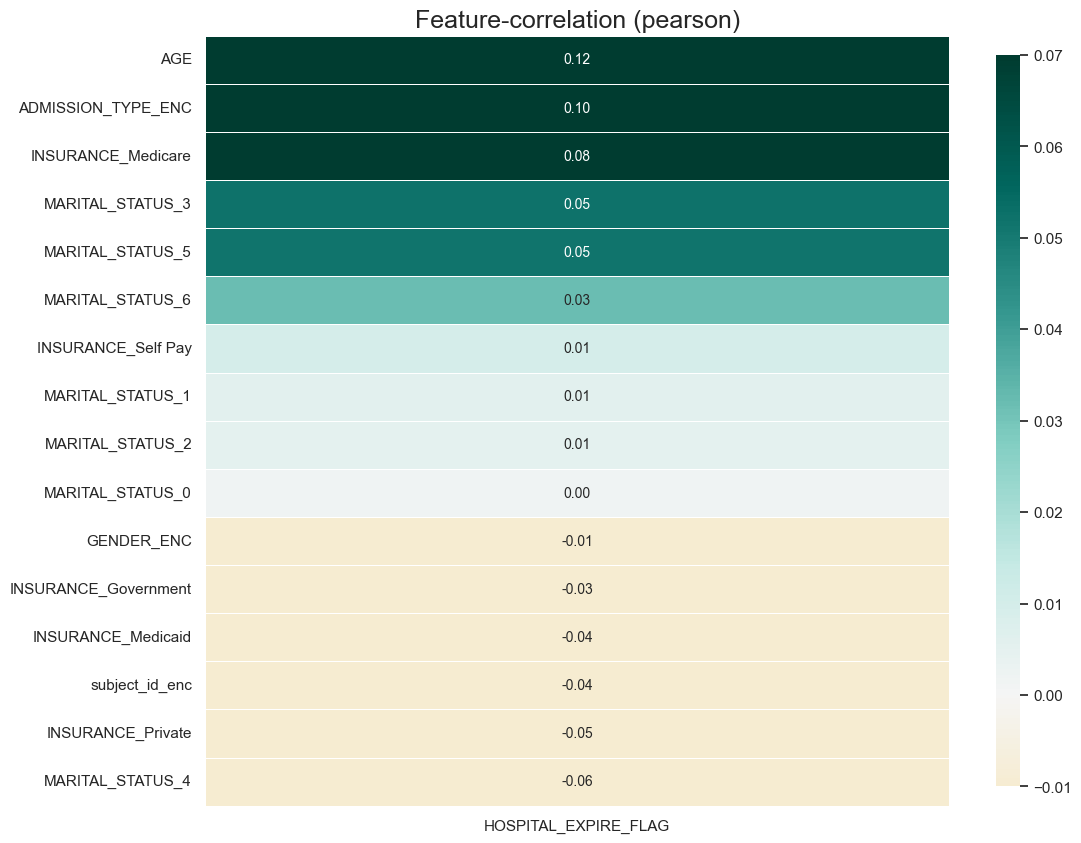

In [533]:
klib.corr_plot(df_train[others], target='HOSPITAL_EXPIRE_FLAG') # default representation of correlations with the feature column

Displaying positive correlations. Specify a positive "threshold" to limit the results further.


<Axes: title={'center': 'Feature-correlation (pearson)'}>

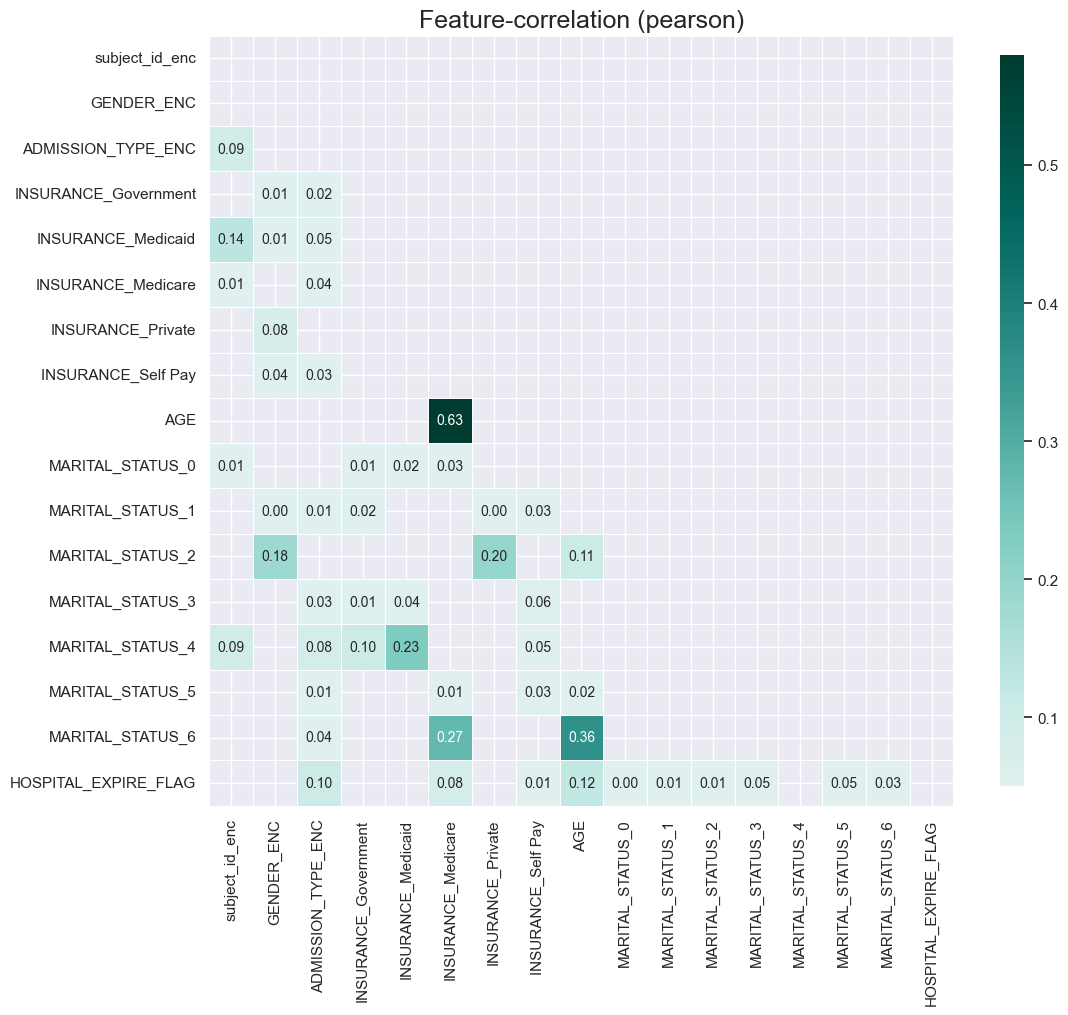

In [534]:
klib.corr_plot(df_train[others],split='pos')

In [535]:
final_list = ['subject_id',
 'hadm_id',
 'icustay_id',
 'HeartRate_Min',
 'HeartRate_Max',
 'SysBP_Min',
 'SysBP_Max',
 'DiasBP_Max',
 'DiasBP_Mean',
 'MeanBP_Max',
 'RespRate_Mean',
 'TempC_Min',
 'TempC_Max',
 'SpO2_Min',
 'SpO2_Max',
 'Glucose_Mean',
 'HOSPITAL_EXPIRE_FLAG',
 'subject_id_enc',
 'GENDER_ENC',
 'ADMISSION_TYPE_ENC',
 'INSURANCE_Government',
 'INSURANCE_Medicaid',
 'INSURANCE_Medicare',
 'INSURANCE_Private',
 'INSURANCE_Self Pay',
 'MARITAL_STATUS_0',
 'MARITAL_STATUS_1',
 'MARITAL_STATUS_2',
 'MARITAL_STATUS_3',
 'MARITAL_STATUS_4',
 'MARITAL_STATUS_5',
 'MARITAL_STATUS_6',
             'AGE']

final_list_t = final_list.copy()
final_list_t.remove('HOSPITAL_EXPIRE_FLAG')

In [536]:
final_list2 = ['subject_id',
 'hadm_id',
 'icustay_id',
 #'HeartRate_Min',
 'HeartRate_Max',
 'HeartRate_Mean',
 'SysBP_Min',
 'SysBP_Max',
 'SysBP_Mean',
 'DiasBP_Min',
 #'DiasBP_Max',
 'DiasBP_Mean',
 'MeanBP_Min',
 #'MeanBP_Max',
 'MeanBP_Mean',
 'RespRate_Min',
 'RespRate_Max',
 'RespRate_Mean',
 'TempC_Min',
 'TempC_Max',
 'TempC_Mean',
 'SpO2_Min',
 'SpO2_Max',
 'SpO2_Mean',
 'Glucose_Min',
 'Glucose_Max',
 'Glucose_Mean',
 'HOSPITAL_EXPIRE_FLAG',
 'subject_id_enc',
 #'GENDER_ENC',
 'ADMISSION_TYPE_ENC',
 'INSURANCE_Government',
 'INSURANCE_Medicaid',
 #'INSURANCE_Medicare',
 'INSURANCE_Private',
 #'INSURANCE_Self Pay',
 #'MARITAL_STATUS_0',
 #'MARITAL_STATUS_1',
 #'MARITAL_STATUS_2',
 'MARITAL_STATUS_3',
 'MARITAL_STATUS_4',
 'MARITAL_STATUS_5',
 #'MARITAL_STATUS_6'
               'AGE'
              ]

final_list2_t = final_list2.copy()
final_list2_t.remove('HOSPITAL_EXPIRE_FLAG')

### Preparing Train and Test dataset for model fitting

In [546]:
from sklearn.model_selection import train_test_split
# In case we use directly a Train and Test datatset
Xtrain = df_train[final_list2].drop(['HOSPITAL_EXPIRE_FLAG','subject_id','hadm_id','icustay_id'],axis = 1)
ytrain = df_train[final_list2]['HOSPITAL_EXPIRE_FLAG']
Xtest_id = df_test[final_list2_t][['icustay_id']]
Xtest = df_test[final_list2_t].drop(['subject_id','hadm_id','icustay_id'],axis = 1) #probably it doesnt require to remove any column

### Dataset Imbalance

In [547]:
print(Xtrain.shape)
print(Xtest.shape)

(20885, 30)
(5221, 30)


In [548]:
table = pd.DataFrame(ytrain.value_counts())
table = table.reset_index()
table['total'] = table['count'].sum()
table['perc'] = table['count'] / table['total']
table

,HOSPITAL_EXPIRE_FLAG,count,total,perc
0,0,18540,20885,0.887718
1,1,2345,20885,0.112282


### Adjusting Imbalance

In [549]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy=0.50)
X_res, y_res = smt.fit_resample(Xtrain, ytrain)

In [550]:
table = pd.DataFrame(y_res.value_counts())
table = table.reset_index()
table['total'] = table['count'].sum()
table['perc'] = table['count'] / table['total']
table

,HOSPITAL_EXPIRE_FLAG,count,total,perc
0,0,18518,27766,0.666931
1,1,9248,27766,0.333069


## Running SVM

In [551]:
## Creating a sample
sample_fraction = 0.3

# Create a random sample
X_res_sample = X_res.sample(frac=sample_fraction, random_state=42)  # Set random_state for reproducibility
y_res_sample = y_res.sample(frac=sample_fraction, random_state=42)  # Set random_state for reproducibility

In [552]:
table = pd.DataFrame(y_res_sample.value_counts())
table = table.reset_index()
table['total'] = table['count'].sum()
table['perc'] = table['count'] / table['total']
table

,HOSPITAL_EXPIRE_FLAG,count,total,perc
0,0,5553,8330,0.666627
1,1,2777,8330,0.333373


In [559]:
# Create a Support Vector Machine classifier with a linear kernel
classifier = SVC(kernel='linear', probability=True,C = 10)

# Train the classifier on the training set
classifier.fit(X_res_sample, y_res_sample)

y_train_probs = classifier.predict_proba(Xtest)[:, 1]

In [560]:
# Produce .csv for kaggle testing
test_predictions_submit_SVM = pd.DataFrame({"icustay_id": Xtest_id['icustay_id'], "HOSPITAL_EXPIRE_FLAG": y_train_probs})
test_predictions_submit_SVM.to_csv("test_predictions_submit_svm_sample6.csv", index = False)

### GridSearchCV

In [553]:
from sklearn.model_selection import GridSearchCV

#Svc = SVC(kernel='rbf')
my_balanced_SVM_model = SVC(class_weight='balanced')

grid_values = {'C':[10, 20], 'gamma':[0.1,0.25,0.5,0.75], 'kernel':['linear', 'rbf']}
grid_svc_acc = GridSearchCV(my_balanced_SVM_model, param_grid = grid_values,scoring = 'roc_auc', cv=5)

grid_svc_acc.fit(X_res_sample, y_res_sample)

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced'),
             param_grid={'C': [10, 20], 'gamma': [0.1, 0.25, 0.5, 0.75],
                         'kernel': ['linear', 'rbf']},
             scoring='roc_auc')

best parameters: {'C': 10, 'gamma': 0.25, 'kernel': 'rbf'}
best score:      0.91163 (+/-0.00357)


,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,10,0.25,rbf,"{'C': 10, 'gamma': 0.25, 'kernel': 'rbf'}",0.913369,0.915017,0.912034,0.904757,0.912985,0.911633,0.003570,1
11,20,0.25,rbf,"{'C': 20, 'gamma': 0.25, 'kernel': 'rbf'}",0.913549,0.914981,0.911897,0.903924,0.912838,0.911438,0.003889,2
5,10,0.5,rbf,"{'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}",0.907283,0.910967,0.906332,0.898629,0.909693,0.906581,0.004306,3
13,20,0.5,rbf,"{'C': 20, 'gamma': 0.5, 'kernel': 'rbf'}",0.907263,0.910881,0.906332,0.897237,0.909686,0.906280,0.004807,4
7,10,0.75,rbf,"{'C': 10, 'gamma': 0.75, 'kernel': 'rbf'}",0.902828,0.904934,0.898535,0.893660,0.907451,0.901481,0.004883,5
15,20,0.75,rbf,"{'C': 20, 'gamma': 0.75, 'kernel': 'rbf'}",0.902831,0.904925,0.898535,0.893660,0.907448,0.901480,0.004881,6
1,10,0.1,rbf,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.897051,0.905203,0.903559,0.884878,0.902735,0.898685,0.007429,7
9,20,0.1,rbf,"{'C': 20, 'gamma': 0.1, 'kernel': 'rbf'}",0.895168,0.901668,0.903687,0.883826,0.899862,0.896842,0.007092,8
0,10,0.1,linear,"{'C': 10, 'gamma': 0.1, 'kernel': 'linear'}",0.768390,0.766379,0.782770,0.763463,0.761459,0.768492,0.007525,9
2,10,0.25,linear,"{'C': 10, 'gamma': 0.25, 'kernel': 'linear'}",0.768390,0.766379,0.782770,0.763463,0.761459,0.768492,0.007525,9


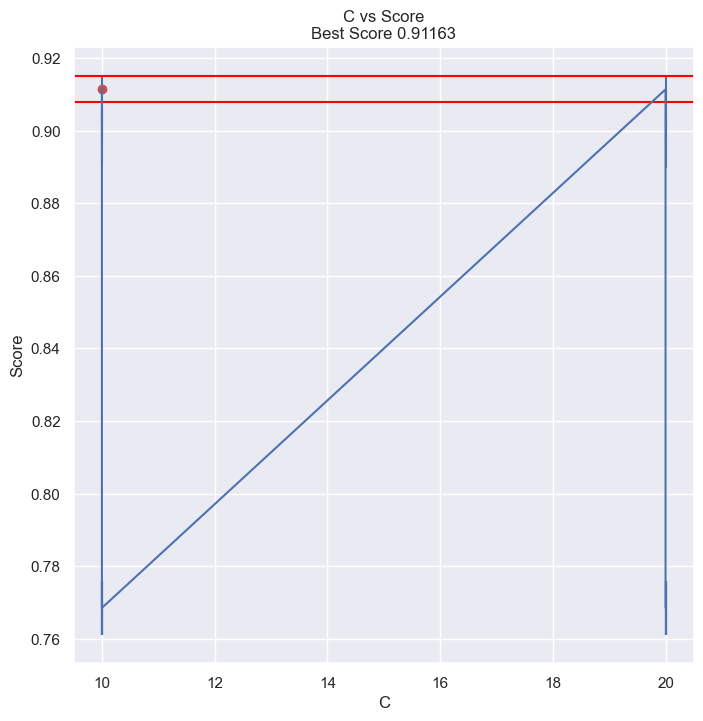

Best Cost parameter : 10
Best gamma parameter : 0.25


In [554]:
# Report best C and gamma
GridSearch_table_plot(grid_svc_acc, "C", negative=False, display_all_params=False)
print('Best Cost parameter : '+ str(grid_svc_acc.best_estimator_.C))
print('Best gamma parameter : '+ str(grid_svc_acc.best_estimator_.gamma))

In [555]:
insample_y_pred_acc = grid_svc_acc.predict(X_res)

# Compute different Evaluation metrics
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix

print('Accuracy Score : ' + str(accuracy_score(y_res,insample_y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_res,insample_y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_res,insample_y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_res,insample_y_pred_acc)))

Accuracy Score : 0.9173089389901318
Precision Score : 0.9160881015082595
Recall Score : 0.827530276816609
F1 Score : 0.8695602772412225


Confusion matrix


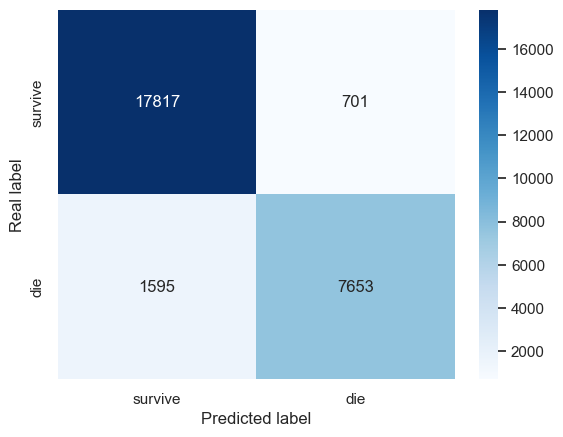

y actual : 
HOSPITAL_EXPIRE_FLAG
0    18518
1     9248
Name: count, dtype: int64
y predicted : 
0    19412
1     8354
Name: count, dtype: int64


In [556]:
#Confusion matrix
print("Confusion matrix")
cm=confusion_matrix(y_res,insample_y_pred_acc)
plot_confusion_matrix(cm, ['survive','die'])
#Distribution of y test
print('y actual : \n' +  str(y_res.value_counts()))
#Distribution of y predicted
print('y predicted : \n' + str(pd.Series(insample_y_pred_acc).value_counts()))

### Final Model

In [557]:
# Create a Support Vector Machine classifier with a linear kernel
classifierF = SVC(class_weight='balanced',kernel='rbf', probability=True, C=10, gamma=0.25)

# Train the classifier on the training set
classifierF.fit(X_res_sample, y_res_sample)

y_train_probs_svc = classifierF.predict_proba(Xtest)[:, 1]

In [558]:
# Produce .csv for kaggle testing
test_predictions_submit_SVM = pd.DataFrame({"icustay_id": Xtest_id['icustay_id'], "HOSPITAL_EXPIRE_FLAG": y_train_probs_svc})
test_predictions_submit_SVM.to_csv("test_predictions_submit_svm_grid_ff_WWW.csv", index = False)

### Running KNN

In [542]:
# Step 1 - Create an instance of the KNN model
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

KNN_model  = KNeighborsClassifier(n_neighbors=20, algorithm = 'brute',weights='distance')
KNN_model.fit(X_res,y_res)

print(f"Predicted class is ",KNN_model.predict(Xtest))
## Check which other algorithm should we try

Predicted class is  [0 0 0 ... 0 0 0]


In [543]:
y_predict_proba = KNN_model.predict_proba(Xtest)

In [544]:
y_proba = pd.DataFrame(y_predict_proba[:,1])

In [545]:
# Produce .csv for kaggle testing
test_predictions_submit = pd.DataFrame({"icustay_id": Xtest_id['icustay_id'], "HOSPITAL_EXPIRE_FLAG": y_proba[0]})
test_predictions_submit.to_csv("test_predictions_submit_knn_new_model8.csv", index = False)